In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# %pwd
# %cd ~/Desktop/whynot

In [3]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

# import whynot as wn
import whynot.gym as gym

from scripts import utils

%matplotlib inline
import whynot.simulators.covid19 as covid19

In [4]:
env = gym.make('COVID19-v0')
env.seed(1);

In [5]:
class NoTreatmentPolicy():
    def sample_action(self, obs):
        return np.ones(env.action_space.shape)
    
class SocialDistancingPolicy():
    def __init__(self, social_distance_rate):
        self.social_distance_rate = social_distance_rate
        
    def sample_action(self, obs):
        return np.array([1.0, 1 - self.social_distance_rate, 1.0])
    
policies = {
    "No Treatment": NoTreatmentPolicy(),
    "Social Distance 10%": SocialDistancingPolicy(0.1),
    "Social Distance 25%": SocialDistancingPolicy(0.25),
    "Social Distance 50%": SocialDistancingPolicy(0.5),
    "Social Distance 100%": SocialDistancingPolicy(1.0),
}

In [6]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

In [7]:
def plot_sample_trajectory(policies):
    """Plot sample trajectories from policies."""
    obs_dim_names = covid19.State.variable_names()

    fig, axes = plt.subplots(4, 3, sharex=True, figsize=[18, 15])
    axes = axes.flatten()
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
            ymin, ymax = axes[i].get_ylim()
        
        # Plot actions
        
        actions = np.array(trajectory["action"])
        for idx, label in enumerate(["sigma", "beta", "mu"]):
            ax_idx = len(obs_dim_names) + idx
            axes[ax_idx].plot(actions[:, idx], label=name)
            axes[ax_idx].set_ylabel(label)
#             axes[ax_idx].set_ylim(0.0, 1.0)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
    
        print(f"Total reward for {name}: {np.sum(reward):.2f}")
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Day")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

Total reward for No Treatment: -2591427584.00
Total reward for Social Distance 10%: -2465568512.00
Total reward for Social Distance 25%: -2181365760.00


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Total reward for Social Distance 50%: -1129299584.00
Total reward for Social Distance 100%: -685321.88


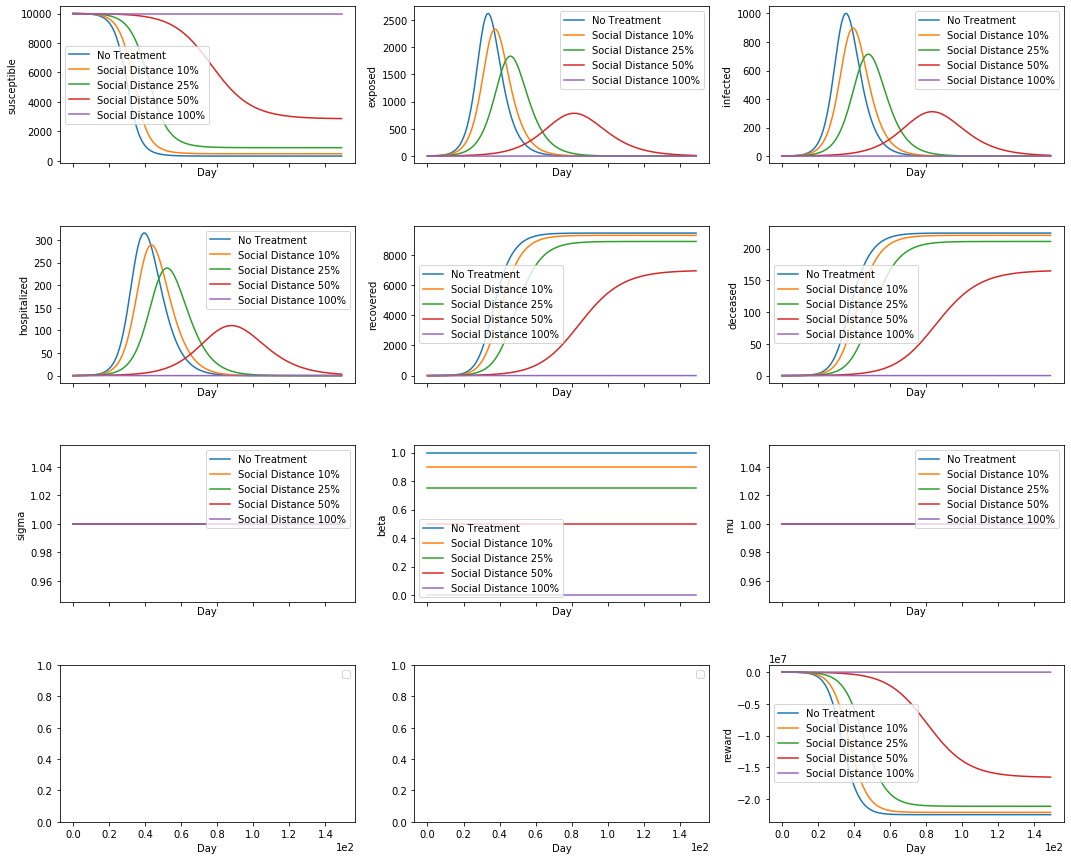

In [8]:
plot_sample_trajectory(policies)

References:

1. https://wwwnc.cdc.gov/eid/article/26/6/20-0233_article
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6332839/